# Logistic Regression

Binary Classification model that finds the optimal the weights and bias and returns probabilites of the two classes

In [1]:
# import numpy as np
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad as egrad

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn.datasets as skdatasets

from celluloid import Camera
import scienceplots
from IPython.display import Image

np.random.seed(0)
plt.style.use(["science", "no-latex"])

## Training Dataset

Let's import the breast cancer dataset. The logistic regression will perform binary classification using the mean perimeter and mean radius of the tumor.

Text(0.5, 1.0, 'Breast Cancer Dataset')

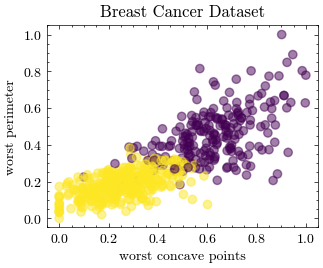

In [2]:
dataset = skdatasets.load_breast_cancer()

features_used = [-3, -8]
X = dataset.data[:, features_used]
feature_names = dataset.feature_names[features_used]

# min-max normalize the features along the columns
X_min_vals = X.min(axis=0)
X_max_vals = X.max(axis=0)
X = (X - X_min_vals) / (X_max_vals - X_min_vals)

Y = dataset.target
target_names = dataset.target_names

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(X[:, 0], X[:, 1], c=Y, alpha=0.5)
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_title("Breast Cancer Dataset")

## Activation Function

Recall that the output of the perceptron was the dot product between the weight vector $\vec{w}$ and the input vector $\vec{x}$ plus a constant bias term $b$

Perceptron: $y=w^Tx + b$

Activation functions are applied after the computation.

### Sigmoid Function

In order to do binary classification, we would like to limit the value of the output to be in the range (0, 1) and get a value to represent the probability of the output being assigned to either class. The sigmoid function is perfect for this

$
\sigma(z) = \frac{1}{1+e^-z}
$

In [3]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

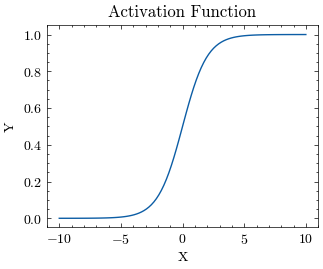

In [4]:
def plot(fx, x_min, x_max, points=100, title=""):

    x = np.linspace(x_min, x_max, points)
    y = fx(x)

    fig, axes = plt.subplots()
    axes.plot(x, y)
    axes.set_xlabel("X")
    axes.set_ylabel("Y")
    axes.set_title("Activation Function")


x_min = -10
x_max = 10
points = 100
plot(sigmoid, x_min, x_max, points)

## Gradient of Sigmoid Function

Gradient Descent will be used later to find the optimal weight values. As a result, let's calculate the gradient of the sigmoid function.

$
\begin{align*}
\sigma^\prime
&= \frac{\partial}{\partial z} \sigma(z) \\
&= \frac{\partial}{\partial z} (\frac{1}{1+e^{-z}}) \\
&= \frac{\partial}{\partial z} (1+e^{-z})^{-1}) \\
&= (-1)(1+e^{-z})^{-2}\frac{\partial}{\partial z}(1+e^{-z}) \\
&= (-1)(1+e^{-z})^{-2}(e^{-z})\frac{\partial}{\partial z}(-z) \\
&= (-1)(1+e^{-z})^{-2}(e^{-z})(-1) \\
&= \frac{e^{-z}}{(1+e^{-z})^{2}}
\end{align*}
$

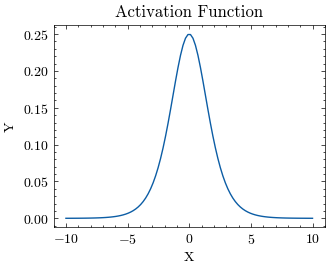

In [5]:
sigmoid_prime = lambda x: np.exp(-x) / np.power((1 + np.exp(-x)), 2)
plot(sigmoid_prime, x_min, x_max, points)

## Autograd
Alternatively, you can use autograd to differentiate a numpy function. Pytorch and JAX also implement autograd.

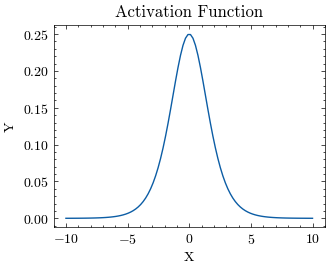

In [6]:
# grad() differentiates scalar inputs
sigmoid_prime_grad = grad(sigmoid)
# egrad() differentiates vectorized inputs
sigmoid_prime_egrad = egrad(sigmoid)

x = np.linspace(x_min, x_max, points)
assert sigmoid_prime_grad(x[0]) == sigmoid_prime(x[0])
assert np.allclose(sigmoid_prime_egrad(x), sigmoid_prime(x))

plot(sigmoid_prime_egrad, x_min, x_max, points)

## Loss Function

The binary cross entropy loss function will be used for logistic regression. This loss function is derived from the definition of maximum likelihood estimation.

For the binary classification model, the probability of seeing the first class is the sigmoid activation function is applied over the sum of the bias $b$ and the dot product of the weight vector $\vec{w}$ and the input vector $\vec{x}$. The probability of seeing the other class is the difference between 1 and the probability of seeing the other class.

$
P(Y=1 \mid \vec{x}; \vec{w}, b) = \sigma{(\vec{w} \cdot \vec{x} + b)}
$

$
P(Y=0 \mid \vec{x}; \vec{w}, b) = 1 - P(Y=1 \mid \vec{x}; \vec{w}, b)
$

### Maximum Likelihood Estimation

Maximum likelihhod estimation finds the optimal weights and bias to maximize the probability of seeing the training data.

The probability of getting the correct binary prediction function in terms of $\vec{w}$ and $b$ is the following. This can also be thought of as a Bernoulli distribution.

$
P(Y \mid \vec{x}; \vec{w}, b) = [\sigma{(\vec{w} \cdot \vec{x} + b)}]^{y} [1 - \sigma{(\vec{w} \cdot \vec{x} + b)}]^{1-y}
$

With a training dataset of $i$ examples of $\vec{x_i}$ features and $y_i$ labels, so the total probability is written as the product of the probabilites of all the training examples. Consider this as the likelihood of the training dataset with the current weights and bias.

$
P(Y \mid \vec{x_i}; \vec{w}, b) = \prod_{i=1}^{n} [\sigma{(\vec{w} \cdot \vec{x_i} + b)}]^{y_i} [1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)}]^{1-y_i}
$

Keep in mind that we want to find the set of optimal parameters $\vec{w}$ and $b$ that maximize the total likelihood.

$
P(Y \mid \vec{x_i}; \vec{w}, b) = \max_{\vec{w}, b} \prod_{i=1}^{n} [\sigma{(\vec{w} \cdot \vec{x_i} + b)}]^{y_i} [1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)}]^{1-y_i}
$

In order to find the optimal weights and bias for the logistic regression model, we use gradient descent, which is a solution to optimization problems. We have to take the partial derivative of the likelihood with respect to $\vec{w}$ and $b$. 

In it's current form, the total probability is a lot of multiplications. Per the product rule for derivatives, the partial derivatives will also be a lot of multiplication. In order to avoid this, we can take the logarithm of the likelihood, which converts the multiplications into additions.

$
\begin{align*}
\ln(P(Y \mid \vec{x_i}; \vec{w}, b)) &= \max_{\vec{w}, b} \ln(\prod_{i=1}^{n} [\sigma{(\vec{w} \cdot \vec{x_i} + b)}]^{y_i} [1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)}]^{1-y_i}) \\
&= \max_{\vec{w}, b} \sum_{i=1}^{n}[ \ln([\sigma{(\vec{w} \cdot \vec{x_i} + b)}]^{y_i} [1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)}]^{1-y_i})] \\
&= \max_{\vec{w}, b} \sum_{i=1}^{n}[ \ln([\sigma{(\vec{w} \cdot \vec{x_i} + b)}]^{y_i}) + \ln([1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)}]^{1-y_i})] \\
&= \max_{\vec{w}, b} \sum_{i=1}^{n}[ y_i \ln(\sigma{(\vec{w} \cdot \vec{x_i} + b)}) + (1-y_i) \ln(1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)})] \\
\end{align*}
$

We define the negative (multiply equation above by -1) log of the likelihood as the binary cross entropy loss function. Let's also divide by the number of training examples to make this the average loss across the $n$ examples.

$
\begin{align*}
L(\vec{w}, b) = -\frac{1}{n}  \sum_{i=1}^{n}[ y_i \ln(\sigma{(\vec{w} \cdot \vec{x_i} + b)}) + (1-y_i) \ln(1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)})] 
\end{align*}
$

### Binary Cross Entropy Loss Function

Recall that $\hat y = \sigma{(\vec{w} \cdot \vec{x} + b)} = \frac{1}{1+e^-(\vec{w} \cdot \vec{x} + b)}$

To simplify the calculation of the loss, let's rewrite it in terms of $\hat y$

$
\begin{align*}
L(\hat y) &= -\frac{1}{n} \sum_{i=1}^{n} [y_i \ln(\hat y_i) + (1-y_i) \ln(1 - \hat y_i)]
\end{align*}
$

In [7]:
def bce(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

## Loss Function in Terms of W and B

Before taking the partial derivative of the loss function with respect to $\vec{w}$ and $b$. Let's simplify it to make the partial derivative calculaton easier.

$\hat y = \sigma{(\vec{w} \cdot \vec{x} + b)} = \frac{1}{1+e^-(\vec{w} \cdot \vec{x} + b)}$

$
\begin{align*}
L(\vec{w}, b) &= -\frac{1}{n}  \sum_{i=1}^{n}[ y_i \ln(\sigma{(\vec{w} \cdot \vec{x_i} + b)}) + (1-y_i) \ln(1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)})] \\ 
&= -\frac{1}{n}  \sum_{i=1}^{n}[ y_i \ln(\sigma{(\vec{w} \cdot \vec{x_i} + b)}) - y_i \ln(1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)}) + \ln(1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)})] \\ 
&= -\frac{1}{n}  \sum_{i=1}^{n}[ y_i \ln(\frac{\sigma{(\vec{w} \cdot \vec{x_i} + b)}}{1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)}}) + \ln(1 - \sigma{(\vec{w} \cdot \vec{x_i} + b)})] \\
&= -\frac{1}{n}  \sum_{i=1}^{n}[ y_i \ln(\frac{\frac{1}{1+e^{-(\vec{w} \cdot \vec{x} + b)}}}{1 - \frac{1}{1+e^{-(\vec{w} \cdot \vec{x} + b)}}}) + \ln(1 - \frac{1}{1+e^{-(\vec{w} \cdot \vec{x} + b)}})] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i \ln(e^{\vec{w} \cdot \vec{x_i} + b}) + \ln(\frac{1}{1+e^{\vec{w} \cdot \vec{x_i} + b}})] \\ 
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i (\vec{w} \cdot \vec{x_i} + b) - \ln(1+e^{\vec{w} \cdot \vec{x_i} + b})] \\ 
\end{align*}
$

## Loss Function Gradient


Loss function with respect to $W$
 
$
\begin{align*}
\nabla_{W} [L(\vec{w}, b)] &= \nabla_{W} [-\frac{1}{n} \sum_{i=1}^{n} [y_i (\vec{w} \cdot \vec{x_i} + b) - \ln(1+e^{\vec{w} \cdot \vec{x_i} + b})]] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i \nabla_{W} [\vec{w} \cdot \vec{x_i} + b] - \nabla_{W}[\ln(1+e^{\vec{w} \cdot \vec{x_i} + b})]] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i x_i - (\frac{1}{1+e^{\vec{w} \cdot \vec{x_i} + b}}) \nabla_{W}[1+e^{\vec{w} \cdot \vec{x_i} + b}]] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i x_i - (\frac{1}{1+e^{\vec{w} \cdot \vec{x_i} + b}}) (e^{\vec{w} \cdot \vec{x_i} + b})\nabla_{W}[\vec{w} \cdot \vec{x_i} + b]] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i x_i - (\frac{1}{1+e^{\vec{w} \cdot \vec{x_i} + b}}) (e^{\vec{w} \cdot \vec{x_i} + b})(x_i)] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i x_i - x_i(\frac{e^{\vec{w} \cdot \vec{x_i} + b}}{1+e^{\vec{w} \cdot \vec{x_i} + b}})] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i x_i - x_i(\frac{1}{1+e^{-(\vec{w} \cdot \vec{x_i} + b)}})] \\ 
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i x_i - x_i\hat y_i] \\ 
&= \frac{1}{n} \sum_{i=1}^{n} [\hat y_i x_i - y_i x_i  ] \\ 
&= \frac{1}{n} \sum_{i=1}^{n} [x_i (\hat y_i - y_i)] \\
\end{align*}
$

In [8]:
def bce_dw(x, y_true, y_pred):
    return np.mean(x * (y_pred - y_true))

Loss function with respect to $b$

$
\begin{align*}
\frac{\partial}{\partial b}  [L(\vec{w}, b)] &= \frac{\partial}{\partial b} [-\frac{1}{n} \sum_{i=1}^{n} [y_i (\vec{w} \cdot \vec{x_i} + b) - \ln(1+e^{\vec{w} \cdot \vec{x_i} + b})]] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i \frac{\partial}{\partial b} [\vec{w} \cdot \vec{x_i} + b] - \frac{\partial}{\partial b}[\ln(1+e^{\vec{w} \cdot \vec{x_i} + b})]] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i (1) - (\frac{1}{1+e^{\vec{w} \cdot \vec{x_i} + b}}) \frac{\partial}{\partial b}[1+e^{\vec{w} \cdot \vec{x_i} + b}] ] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i - (\frac{1}{1+e^{\vec{w} \cdot \vec{x_i} + b}}) (e^{\vec{w} \cdot \vec{x_i} + b}) \frac{\partial}{\partial b}[\vec{w} \cdot \vec{x_i} + b]] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i - (\frac{1}{1+e^{\vec{w} \cdot \vec{x_i} + b}}) (e^{\vec{w} \cdot \vec{x_i} + b}) (1)] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i - (\frac{e^{\vec{w} \cdot \vec{x_i} + b}}{1+e^{\vec{w} \cdot \vec{x_i} + b}})] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i - (\frac{1}{1+e^-({\vec{w} \cdot \vec{x_i} + b})})] \\
&= -\frac{1}{n} \sum_{i=1}^{n} [y_i - \hat y_i] \\
&= \frac{1}{n} \sum_{i=1}^{n} (\hat y_i - y_i) \\
\end{align*}
$

In [9]:
def bce_db(y_true, y_pred):
    return np.mean(y_pred - y_true)

## Gradient Descent

With the binary cross entropy functions with respect to $\vec{w}$ and $b$, the gradient descent equations are:

Gradient Descent for weights $\vec{w}$

$
\begin{align*}
\vec{w} &= \vec{w} - \eta \nabla_{W} [L(\vec{w}, b)] \\
&= \vec{w} - \eta [\frac{1}{n} \sum_{i=1}^{n} [x_i (\hat y_i - y_i)]]
\end{align*}
$

Gradient Descent for bias $b$

$
\begin{align*}
b &= b - \eta \frac{\partial}{\partial b} [L(\vec{w}, b)] \\
&= b - \eta [\frac{1}{n} \sum_{i=1}^{n} (\hat y_i - y_i)]
\end{align*}
$

In [10]:
def gradient_descent(weights, x, bias, y_true, y_pred, learning_rate):
    weights = weights - learning_rate * bce_dw(x, y_true, y_pred)
    bias = bias - learning_rate * bce_db(y_true, y_pred)

    return weights, bias

## Graphing functions

Utility functions to create the visualizations

In [11]:
def create_plots():
    fig, ax = plt.subplots(1, 3, figsize=(16 / 9.0 * 4, 4 * 1))
    fig.suptitle("Logistic Regression")

    ax[0].set_xlabel("Epoch", fontweight="normal")
    ax[0].set_ylabel("Error", fontweight="normal")
    ax[0].set_title("Binary Cross Entropy Error")

    ax[1].axis("off")
    ax[2].axis("off")

    ax[2] = fig.add_subplot(1, 2, 2, projection="3d")
    ax[2].set_xlabel("X")
    ax[2].set_ylabel("Y")
    ax[2].set_zlabel("Z")
    ax[2].set_title("Prediction Probabilities")
    ax[2].view_init(20, -35)

    camera = Camera(fig)
    return ax[0], ax[2], camera


def plot_graphs(
    ax0,
    ax1,
    idx,
    visible_mse,
    mse_idx,
    errors,
    features,
    labels,
    predictions,
    points_x,
    points_y,
    surface_predictions,
):
    ax0.plot(
        mse_idx[visible_mse][: idx + 1],
        errors[visible_mse][: idx + 1],
        color="red",
        alpha=0.5,
    )

    # Plot Logistic Regression Predictions
    # Ground truth and training data
    ground_truth_legend = ax1.scatter(
        features[:, 0],
        features[:, 1],
        labels,
        color="red",
        alpha=0.5,
        label="Ground Truth",
    )
    # Logistic Regression Predictions
    predictions_legend = ax1.scatter(
        features[:, 0],
        features[:, 1],
        predictions,
        color="blue",
        alpha=0.2,
        label="Prediction",
    )
    ax1.plot_surface(
        points_x,
        points_y,
        surface_predictions.reshape(dims, dims),
        color="blue",
        alpha=0.2,
    )
    ax1.legend(
        (ground_truth_legend, predictions_legend),
        ("Ground Truth", "Predictions"),
        loc="upper left",
    )

## Training the model

In [12]:
def fit(
    w0, b0, features, labels, dims, epochs, learning_rate, optimizer, output_filename
):
    mse_idx = np.arange(1, epochs + 1)
    errors = np.full(epochs, -1)
    ax0, ax1, camera = create_plots()

    points = np.linspace(0, 1, dims)
    points_x, points_y = np.meshgrid(points, points)
    surface_points = np.column_stack((points_x.flatten(), points_y.flatten()))

    weights = w0
    bias = b0

    for idx in range(epochs):
        error = 0
        predictions = np.array([])
        surface_predictions = np.array([])

        # fit the model on the training data
        for x, y in zip(features, labels):
            output = sigmoid(np.dot(weights, x) + bias)

            predictions = np.append(predictions, output)

            # Store Error
            error += bce(y, output)

            # Gradient Descent
            weights, bias = optimizer(weights, x, bias, y, output, learning_rate)

        # error /= len(features)

        # Visualization
        if (
            idx < 5
            or (idx < 15 and idx % 5 == 0)
            or (idx <= 50 and idx % 25 == 0)
            or (idx <= 1000 and idx % 200 == 0)
            or idx % 500 == 0
        ):
            for surface_point in surface_points:
                output = sigmoid(np.dot(weights, surface_point) + bias)
                surface_predictions = np.append(surface_predictions, output)

            print(f"epoch: {idx:>4}, BCA: {round(error, 2)}")

            # Plot BCE
            errors[idx] = error
            visible_mse = errors != -1

            plot_graphs(
                ax0,
                ax1,
                idx,
                visible_mse,
                mse_idx,
                errors,
                features,
                labels,
                predictions,
                points_x,
                points_y,
                surface_predictions,
            )

            camera.snap()

    animation = camera.animate()
    animation.save(output_filename, writer="pillow")

epoch:    0, BCA: 444.23
epoch:    1, BCA: 438.52
epoch:    2, BCA: 433.32
epoch:    3, BCA: 428.58
epoch:    4, BCA: 424.25
epoch:    5, BCA: 420.28
epoch:   10, BCA: 404.5
epoch:   25, BCA: 375.53
epoch:   50, BCA: 341.83
epoch:  200, BCA: 231.95
epoch:  400, BCA: 176.56
epoch:  500, BCA: 161.66
epoch:  600, BCA: 150.72
epoch:  800, BCA: 135.71
epoch: 1000, BCA: 125.86
epoch: 1500, BCA: 111.57
epoch: 2000, BCA: 103.85
epoch: 2500, BCA: 99.03
epoch: 3000, BCA: 95.75
epoch: 3500, BCA: 93.39
epoch: 4000, BCA: 91.61
epoch: 4500, BCA: 90.24
epoch: 5000, BCA: 89.16


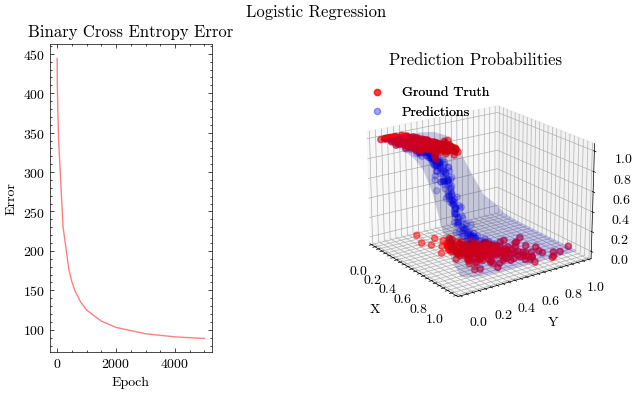

In [13]:
epochs = 5001
learning_rate = 0.0005
dims = 10

w0 = np.random.rand(X[0].shape[0])
b0 = np.random.rand()

output_filename = "logistic_regression.gif"
fit(w0, b0, X, Y, dims, epochs, learning_rate, gradient_descent, output_filename)

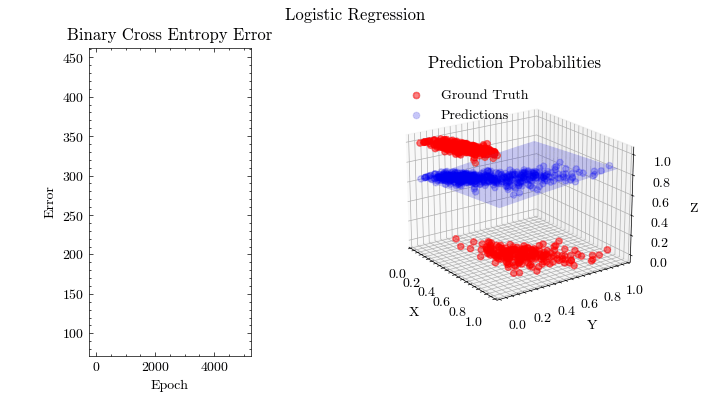

In [14]:
Image(filename=output_filename)